# CARNIVAL

CARNIVAL (CAusal Reasoning for Network identification using Integer VALue programming) is a method for the identification of upstream reguatory signalling pathways from downstream gene expression (GEX). Applications of CARNIVAL include the identification of drug’s modes of action and of deregulated processes in diseases (even if the molecular targets remain unknown) by deciphering the alterations of main signalling pathways as well as alternative pathways and off-target effects.

<div style="text-align: center; margin: 25px;">
    <img src="/_static/carnival-abstract.png" alt="CARNIVAL abstract" style="width: 100%; max-width: 800px; margin-bottom: 10px;" onerror="this.onerror=null; this.src='https://github.com/saezlab/PerMedCoE_tools_virtual_course_2023/raw/main/assets/carnival_graphical_abstract.png';">
    <br>
    <span style="font-size: smaller; line-height: 1.25em; display: inline-block; margin-top: -2px;">
        <b>Figure 1:</b> Liu A., Trairatphisan P., Gjerga E. et al. From expression footprints to causal pathways: contextualizing large signaling networks with CARNIVAL npj Systems Biology and Applications volume 5, Article number: 40 (2019).
    </span>
</div>

The aim of the CARNIVAL pipeline is to identify a subset of interactions from a prior knowledge network that represent potential regulated pathways linking known or potential targets of perturbation towards active transcription factors derived from GEX data. The pipeline includes a number improved functionalities comparing to the original version and consists of the following processes:

- Transcription factors’ (TFs) activities and pathway scores from gene expressions can be inferred with our in-house tools (Dorothea, CollecTRI).
- TFs’ activities and signed directed protein-protein interaction networks with or without the provided target of perturbations and pathway scores are then used to construct an optimization problem with CORNETO.
- CORNETO is used to solve the optimization problem with any of the supported solvers (CPLEX, GUROBI, SCIPY, etc), which identifies the sub-network topology with minimised fitting error and model size.



The original version of CARNIVAL was implemented in R and CPLEX. The new re-implementationo of CARNIVAL in CORNETO support a wide variety of solvers thanks to the support of both CVXPY and PICOS. It also has more flexibility since the problem is symbolically defined, and can be modified through the CORNETO API after creating the CARNIVAL problem. This gives user extra flexibility to modify the problem or to use CORNETO as a building block for other optimization problems. 


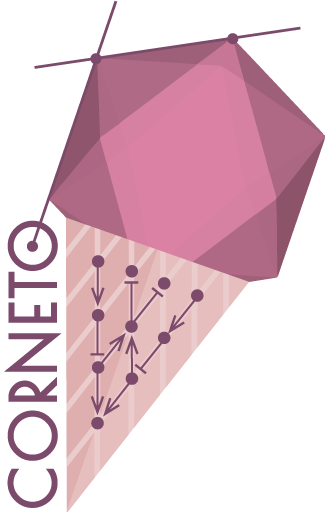

In [1]:
import numpy as np
import corneto as cn
import pandas as pd

cn.info()

## Creating a toy example

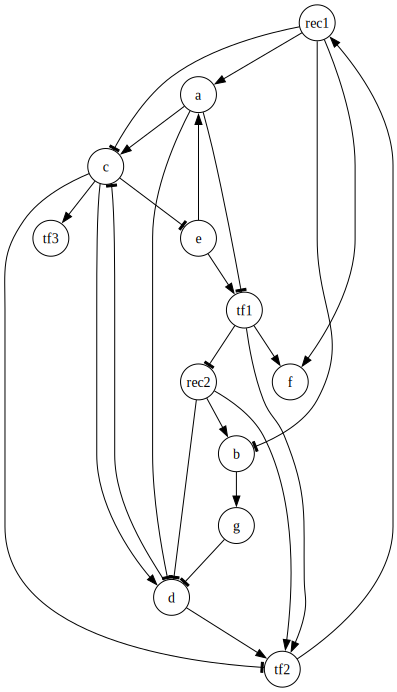

In [2]:
from corneto.graph import Graph

G = Graph.from_tuples(
    [
        ("rec1", 1, "a"),
        ("rec1", -1, "b"),
        ("rec1", 1, "f"),
        ("rec1", -1, "c"),
        ("rec2", 1, "b"),
        ("rec2", 1, "tf2"),
        ("b", 1, "g"),
        ("g", -1, "d"),
        ("rec2", -1, "d"),
        ("a", 1, "c"),
        ("a", -1, "d"),
        ("c", 1, "d"),
        ("c", -1, "e"),
        ("c", 1, "tf3"),
        ("e", 1, "a"),
        ("d", -1, "c"),
        ("e", 1, "tf1"),
        ("a", -1, "tf1"),
        ("d", 1, "tf2"),
        ("c", -1, "tf2"),
        ("tf1", 1, "tf2"),
        ("tf1", -1, "rec2"),
        ("tf2", 1, "rec1"),
        ("tf1", 1, "f")
    ]
)
# Plot our PKN
G.plot()

In [3]:
from corneto.methods.future.carnival import CarnivalFlow, CarnivalILP

samples = {
    "input_example": {
        "rec2": {
            "value": 1,
            "mapping": "vertex",
            "role": "input"
        },
        "tf1": {
            "value": -2,
            "mapping": "vertex",
            "role": "output"
        },
        "tf2": {
            "value": 1,
            "mapping": "vertex",
            "role": "output"
        }
    }
}

data = cn.Data.from_cdict(samples)
data

Data(n_samples=1, n_feats=[3])

## CarnivalFlow

Carnival Flow is a generalization of Carnival for multi-samples, using the structured sparsity inducing penalty to regularize solutions taking into account multiple samples. However, in the single sample case, it is equivalent to the original Carnival, although using a complete different formulation.

Unreachable vertices for sample: 0
0.0
5.0


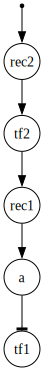

In [4]:
c = CarnivalFlow(lambda_reg=1e-3)
P = c.build(G, data)
P.solve(verbosity=0, solver="scipy")
for o in P.objectives:
    print(o.value)

c.processed_graph.edge_subgraph(np.flatnonzero(P.expr.edge_has_signal.value)).plot()

In [5]:
# Extract the values from the problem
pd.DataFrame(P.expr.edge_value.value, index=c.processed_graph.E, columns=["edge_activity"]).astype(int)

edge_activity
(rec1) (a)                 1
       (b)                 0
       (c)                 0
(rec2) (b)                 0
       (tf2)               1
(b)    (g)                 0
(g)    (d)                 0
(rec2) (d)                 0
(a)    (c)                 0
       (d)                 0
(c)    (d)                 0
       (e)                 0
(e)    (a)                 0
(d)    (c)                 0
(e)    (tf1)               0
(a)    (tf1)              -1
(d)    (tf2)               0
(c)    (tf2)               0
(tf1)  (tf2)               0
       (rec2)              0
(tf2)  (rec1)              1
       ()                  0
(tf1)  ()                  0
()     (rec2)              1

In [6]:
pd.DataFrame(P.expr.vertex_value.value, index=c.processed_graph.V, columns=["node_activity"]).astype(int)

,node_activity
tf2,1
g,0
d,0
rec2,1
b,0
rec1,1
tf1,-1
c,0
a,1
e,0


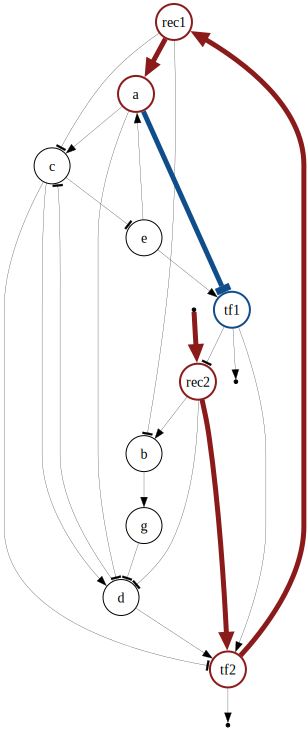

In [7]:
c.processed_graph.plot_values(vertex_values=P.expr.vertex_value.value, edge_values=P.expr.edge_value.value)

## Carnival ILP

For completion, we have a version of the original Carnival that is not based on the modern formulation of CarnivalFlow, cannot be used for multi-samples, and is slower for larger problems.

In [8]:
c = CarnivalILP(beta_weight=1e-3)
P = c.build(G, data)

In [9]:
P.solve(verbosity=0, solver="scipy");

In [10]:
for o in P.objectives:
    print(o.value)

0.0
4.0


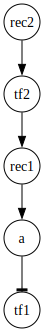

In [11]:
c.processed_graph.edge_subgraph(np.flatnonzero(P.expr.edge_values.value)).plot()

In [12]:
# Extract the values from the problem
pd.DataFrame(P.expr.edge_values.value, index=c.processed_graph.E, columns=["edge_activity"]).astype(int)

edge_activity
(rec1) (a)                 1
       (b)                 0
       (c)                 0
(rec2) (b)                 0
       (tf2)               1
(b)    (g)                 0
(g)    (d)                 0
(rec2) (d)                 0
(a)    (c)                 0
       (d)                 0
(c)    (d)                 0
       (e)                 0
(e)    (a)                 0
(d)    (c)                 0
(e)    (tf1)               0
(a)    (tf1)              -1
(d)    (tf2)               0
(c)    (tf2)               0
(tf1)  (tf2)               0
       (rec2)              0
(tf2)  (rec1)              1

In [13]:
pd.DataFrame(P.expr.vertex_values.value, index=c.processed_graph.V, columns=["node_activity"]).astype(int)

,node_activity
tf2,1
g,0
d,0
rec2,1
b,0
rec1,1
tf1,-1
c,0
a,1
e,0


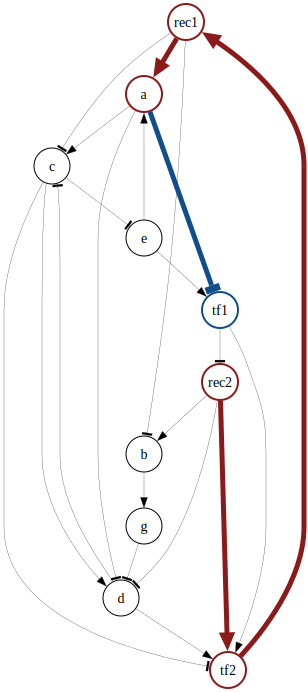

In [14]:
c.processed_graph.plot_values(vertex_values=P.expr.vertex_values.value, edge_values=P.expr.edge_values.value)

## Old implementation

An older implementation used in previous versions of CORNETO is still available in the `corneto.methods.carnival` package. It uses a simpler interface and a formulation more similar to the original CarnivalR:

In [15]:
from corneto.methods.carnival import milp_carnival

P = milp_carnival(
    G,
    {"rec2": 1},
    {"tf1": -2, "tf2": 1},
    beta_weight=1e-3,
) 
P.solve(solver="scipy");

In [16]:
for o in P.objectives:
    print(o.value)

0.0
4.0


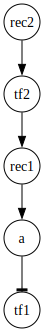

In [17]:
G.edge_subgraph(np.flatnonzero(P.expr.edge_values.value)).plot()